## Автоматическое дифференцирование

In [1]:
import torch
from torch import autograd

In [2]:
x = torch.arange(4).type(torch.float)
print(x)

tensor([0., 1., 2., 3.])


## Присоединение градиента к `x`

- Говорит системе, что мы хотим хранить градиент

In [4]:
x.requires_grad

False

In [5]:
x = x.requires_grad_()

In [6]:
x.requires_grad

True

In [8]:
x.grad

## Forward

вычислим 

$$y = 2\mathbf{x}^{\top}\mathbf{x}$$

In [9]:
y = 2 * x.dot(x)

In [15]:
y

tensor(28., grad_fn=<MulBackward0>)

## Backward

In [16]:
y.backward()

## Получение градиента

$y = 2\mathbf{x}^{\top}\mathbf{x}$, значит 

$$\frac{\partial y}{\partial \mathbf x} = 4\mathbf{x}$$

Проверим:

In [17]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [18]:
4 * x == x.grad

tensor([True, True, True, True])

## no_grad

функция no_grad позволяет отключить вычисление градиента для части кода

In [19]:
y = 2 * x.dot(x)
print(y.grad_fn)
with torch.no_grad():
    y = 2 * x.dot(x)
    print(y.grad_fn)

None


In [20]:
y = 2 * x.dot(x)
y.backward()
print(x.grad)
with torch.no_grad():
    y = 2 * x.dot(x)
    y.backward()
    print(x.grad)

tensor([ 0.,  8., 16., 24.])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Гибкий граф

In [21]:
def f(a):
    b = a * 2
    while b.norm().item() < 1000:
        b = b * 2
    if b.sum().item() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [22]:
a = torch.randn(1).requires_grad_()
d = f(a)
d.backward()

In [23]:
d

tensor([-145757.9531], grad_fn=<MulBackward0>)

In [25]:
a.grad

tensor([1638400.])

## Практика

1. Пусть $f(x) = \sin(x) * x$. Постройте график $f(x)$ и $\frac{df(x)}{dx}$ используя пакет autograd'а для расчета производных (т.е. нельзя выводить производную явно)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
X = []
DIFF_AUTO = []
DIFF_MANUAL = []


In [59]:
for va in range(-2000, 2000, 1):
    v = va / 100.
    X.append(v)
    x = torch.tensor(v, requires_grad=True)
    y = torch.sin(x) * x
    y.backward()
    DIFF_AUTO.append(x.grad.item())
    DIFF_MANUAL.append((torch.cos(x)*x + torch.sin(x)).item())

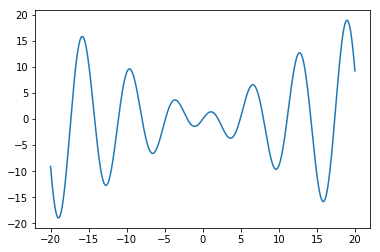

In [60]:
plt.plot(X, DIFF_AUTO)
plt.show()

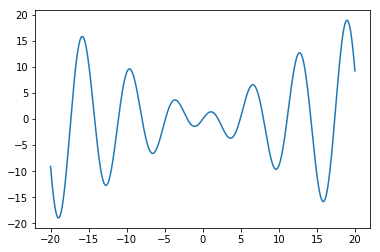

In [61]:
plt.plot(X, DIFF_MANUAL)
plt.show()

In [62]:
x = torch.linspace(-20,20,10000).requires_grad_()

In [63]:
x

tensor([-20.0000, -19.9960, -19.9920,  ...,  19.9920,  19.9960,  20.0000],
       requires_grad=True)

In [64]:
y = torch.sin(x)*x 

In [65]:
y

tensor([18.2589, 18.2225, 18.1857,  ..., 18.1858, 18.2225, 18.2589],
       grad_fn=<MulBackward0>)

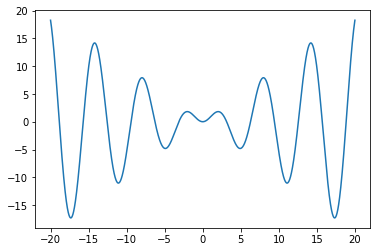

In [66]:
plt.plot(x.detach().numpy(),y.detach().numpy())

In [ ]:
y = torch.sin(x)*x   y = my_graph(x) plt.plot(x.detach().numpy(),y.detach().numpy());

## Линейная регрессия с нуля

In [73]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import torch
import random

## Генерируем данные

- Случайно генерируем $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$
- Выбираем значения весов (истинные): $\mathbf{w} = [2, -3.4]^\top$ и свободного члена $b = 4.2$
- Генерируем метки по формле $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$
  с шумом $\epsilon$ нормально распределнным с мат ожиданием 0 и дисперсией 1

In [69]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

## Визуализируем данные

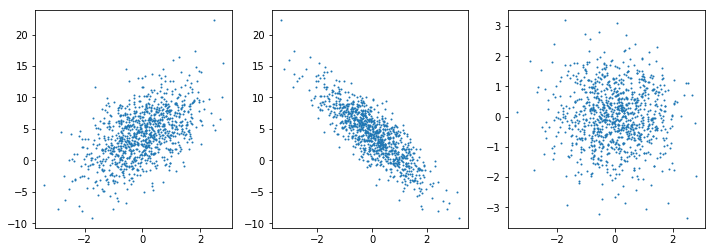

In [70]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(features[:, 0], labels, 1)
plt.subplot(132)
plt.scatter(features[:, 1], labels, 1)
plt.subplot(133)
plt.scatter(features[:, 0], features[:, 1], 1)
plt.show()

## Чтение данных

Итерируемся по датасету и возвращаем случаные `batch_size` примеров.

In [115]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # число 100
    indices = list(range(num_examples)) # список чисел от 0 до 99
    # The examples are read at random, in no particular order
    random.shuffle(indices) # перемешиваем этот список
    for i in range(0, num_examples, batch_size): 
        j = indices[i: min(i + batch_size, num_examples)] # Выбираем индексы для батчка
        yield features[j, :], labels[j] # возвращаем батч

## Выводим маленький батч

In [116]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 1.8487e-03,  1.4930e+00],
        [-5.8614e-01,  9.6554e-01],
        [-3.2053e-01, -2.0647e+00],
        [ 1.0919e+00,  2.3649e-01],
        [ 1.0157e+00,  2.6991e-01],
        [ 6.1532e-01, -1.3473e+00],
        [-9.6910e-01, -7.7849e-02],
        [-5.5635e-01, -5.5024e-01],
        [-1.1311e+00,  3.7834e-01],
        [ 5.5715e-02,  1.7760e+00]]) tensor([-2.1960, -0.4382, 10.7357,  3.6451,  4.2464, 10.2947,  3.0030,  5.2646,
         0.6120, -1.2867])


### Создаем нашу модель для обучения

In [117]:
w = torch.randn((num_inputs))
b = torch.zeros((1,))

In [118]:
w.requires_grad_()
b.requires_grad_()

tensor([0.], requires_grad=True)

## Практика - реализуйте функции:
- linreg - применение модели линейной регресии
- squared_loss - MSE функция потерь
- sgd - стохастический шаг градиентного спуска по массиву параметров

и допишите код обучения линейной регрессии

In [119]:
def linreg(X, w, b):
    return torch.mv(X, w) + b

### Обучение

In [120]:
def squared_loss(y_hat, y):
    return ((y_hat - y.reshape(y_hat.shape)) ** 2).mean()

In [121]:
def sgd(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [122]:
lr = 0.01  
num_epochs = 20

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):   
        w = w.detach()
        b = b.detach()
        w.requires_grad_()
        b.requires_grad_()
        
        l = squared_loss(linreg(X, w, b), y)
        l.backward()
        sgd([w, b], lr)

    train_l = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 1.933140
epoch 2, loss 1.098843
epoch 3, loss 1.079300
epoch 4, loss 1.079197
epoch 5, loss 1.079538
epoch 6, loss 1.079072
epoch 7, loss 1.079403
epoch 8, loss 1.079711
epoch 9, loss 1.078685
epoch 10, loss 1.079363
epoch 11, loss 1.079003
epoch 12, loss 1.079493
epoch 13, loss 1.080378
epoch 14, loss 1.078941
epoch 15, loss 1.079320
epoch 16, loss 1.079160
epoch 17, loss 1.080084
epoch 18, loss 1.078693
epoch 19, loss 1.080001
epoch 20, loss 1.079895


## Оценка качества модели

In [123]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)
print(w)
print(b)

Error in estimating w tensor([-0.0271,  0.0338], grad_fn=<SubBackward0>)
Error in estimating b tensor([-0.0086], grad_fn=<RsubBackward1>)
tensor([ 2.0271, -3.4338], grad_fn=<CopySlices>)
tensor([4.2086], grad_fn=<CopySlices>)


## Линейная регрессия на torch

In [124]:
from torch.utils.data import TensorDataset, DataLoader

In [125]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

In [126]:
batch_size = 10
dataset = TensorDataset(features, labels)
# Randomly reading mini-batches
data_iter = DataLoader(dataset, batch_size, shuffle=True)

# Read a batch to see how it works
for X, y in data_iter:
    print(X, y)
    break

tensor([[ 1.4573,  0.0162],
        [ 0.2359, -1.1205],
        [-0.4728,  0.7606],
        [-0.6177,  1.6416],
        [ 0.6942, -2.2382],
        [ 1.3118, -0.2901],
        [-1.2905,  0.5856],
        [-0.0388,  1.1949],
        [ 1.1616,  0.4260],
        [-0.0416,  0.1493]]) tensor([ 5.8308,  7.4321,  0.5855, -4.1864, 12.7403,  7.6165, -0.1082, -0.4809,
         4.3338,  4.6476])


In [130]:
model = torch.nn.Sequential(torch.nn.Linear(2, 1))

In [131]:
loss = torch.nn.MSELoss(reduction='mean')

In [132]:
trainer = torch.optim.SGD(model.parameters(), lr=0.001)

In [133]:
num_epochs = 20
for epoch in range(0, num_epochs):
    for X, y in data_iter:
        trainer.zero_grad()
        l = loss(model.forward(X).reshape(-1), y)
        l.backward()
        trainer.step()
    l = loss(model.forward(features).reshape(-1), labels)
    print('epoch %d, loss: %f' % (epoch, l.item()))
    print('w', model[0].weight.data)
    print('b', model[0].bias.data)

epoch 0, loss: 27.049585
w tensor([[ 0.3336, -0.6576]])
b tensor([0.3272])
epoch 1, loss: 18.308361
w tensor([[ 0.6446, -1.1797]])
b tensor([1.0364])
epoch 2, loss: 12.501013
w tensor([[ 0.8979, -1.6032]])
b tensor([1.6157])
epoch 3, loss: 8.633993
w tensor([[ 1.1038, -1.9470]])
b tensor([2.0907])
epoch 4, loss: 6.064431
w tensor([[ 1.2712, -2.2261]])
b tensor([2.4787])
epoch 5, loss: 4.356534
w tensor([[ 1.4077, -2.4530]])
b tensor([2.7954])
epoch 6, loss: 3.221164
w tensor([[ 1.5183, -2.6364]])
b tensor([3.0551])
epoch 7, loss: 2.465290
w tensor([[ 1.6086, -2.7860]])
b tensor([3.2671])
epoch 8, loss: 1.963342
w tensor([[ 1.6822, -2.9071]])
b tensor([3.4402])
epoch 9, loss: 1.628416
w tensor([[ 1.7417, -3.0057]])
b tensor([3.5826])
epoch 10, loss: 1.407216
w tensor([[ 1.7903, -3.0846]])
b tensor([3.6983])
epoch 11, loss: 1.258566
w tensor([[ 1.8294, -3.1501]])
b tensor([3.7938])
epoch 12, loss: 1.160679
w tensor([[ 1.8615, -3.2019]])
b tensor([3.8715])
epoch 13, loss: 1.095011
w tenso

In [134]:
w = model[0].weight.data
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = model[0].bias.data
print('Error in estimating b', true_b - b)

Error in estimating w tensor([[ 0.0331, -0.0226]])
Error in estimating b tensor([0.0659])


In [135]:
model[0].weight.data

tensor([[ 1.9669, -3.3774]])

In [136]:
model[0].bias.data

tensor([4.1341])